<font color='blue'> **Freyberg** </font> 
<font color='red'> **on Line** </font> 

In [1]:
import flopy ; import numpy as np ;import matplotlib.pyplot as plt ;from pathlib import Path 
sim_ws=Path("./data/Freyberg")  ;sim_ws2=Path("./a01a")  ;sim_ws2.mkdir(exist_ok=True)  ;sim_name='Freyberg'  

In [2]:
bottom = np.loadtxt(sim_ws / 'bottom.txt')  ; k11 = np.loadtxt(sim_ws / 'hydraulic_conductivity.txt')    ; idomain = np.loadtxt(sim_ws / 'idomain.txt', dtype=np.int32)
length_units="meters"                       ; nlay=1;nrow=40;ncol=20        ; delr=250.0;delc=250.0                                    ; top=35.0;icelltype=1;strt=45.0
time_units="seconds"                        ; recharge=1.60000000e-09       ; nouter=100;ninner=25;hclose=1e-9;rclose=1e-3             ; nper=1; tdis_ds=((1.0,1.0,1),)
wel_spd = {0: [[0,  8, 15, -0.00820000]     ,[0, 10, 12, -0.00410000] ,[0, 19, 13, -0.00390000] ,[0, 25, 9, -8.30000000e-04],
               [0, 28,  5, -7.20000000e-04] ,[0, 33, 11, -0.00430000]]}
chd_spd = {0: [[0, 39,  5, 16.90000000]     ,[0, 39,  6, 16.40000000] ,[0, 39,  7, 16.10000000] ,[0, 39,  8, 15.60000000]   ,[0, 39,  9, 15.10000000],
               [0, 39, 10, 14.00000000]     ,[0, 39, 11, 13.00000000] ,[0, 39, 12, 12.50000000] ,[0, 39, 13, 12.00000000]   ,[0, 39, 14, 11.40000000]]}
rbot = np.linspace(20.0, 10.25, num=nrow)   ; rstage = np.linspace(20.1, 11.25, num=nrow)   ; riv_spd = []
for idx, (s, b) in enumerate(zip(rstage, rbot)): riv_spd.append([0, idx, 14, s, 0.05, b]) 
riv_spd = {0: riv_spd}

In [3]:
sim = flopy.mf6.MFSimulation   (sim_name=sim_name,sim_ws=sim_ws2,exe_name="mf6",)
flopy.mf6.ModflowTdis    (sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
flopy.mf6.ModflowIms     (sim,linear_acceleration="BICGSTAB",outer_maximum=nouter,outer_dvclose=hclose * 10.0,inner_maximum=ninner,
                          inner_dvclose=hclose,rcloserecord=f"{rclose} strict")
gwf = flopy.mf6.ModflowGwf     (sim,modelname=sim_name,newtonoptions="NEWTON UNDER_RELAXATION")
flopy.mf6.ModflowGwfdis  (gwf,length_units=length_units,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,top=top,botm=bottom,idomain=idomain)
flopy.mf6.ModflowGwfnpf  (gwf,icelltype=icelltype,k=k11,)
flopy.mf6.ModflowGwfic   (gwf, strt=strt)
flopy.mf6.ModflowGwfriv  (gwf, stress_period_data = riv_spd, pname="RIV-1")
flopy.mf6.ModflowGwfwel  (gwf, stress_period_data = wel_spd, pname="WEL-1")
flopy.mf6.ModflowGwfrcha (gwf, recharge=recharge)
flopy.mf6.ModflowGwfchd  (gwf, stress_period_data = chd_spd)                                                     # ; bf=f"{sim_name}.cbc"
flopy.mf6.ModflowGwfwel  (gwf,maxbound=1,pname="CF-1",filename=f"{sim_name}.cf.wel")        ; hf=f"{sim_name}.hds" ; bf=f"{sim_name}.bud"
flopy.mf6.ModflowGwfoc   (gwf ,head_filerecord=hf,budget_filerecord=bf,headprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
                         saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")] ,printrecord=[("HEAD", "ALL"), ("BUDGET", "ALL")])  
sim.write_simulation(silent=True)  ; sim.run_simulation(silent=True) 

(True, [])

In [4]:
from flopy.utils.postprocessing import get_water_table  
gwf = sim.get_model(sim_name) ; heads = gwf.output.head()  ;hds = gwf.output.head() ; head = hds.get_alldata()[0] ; wt = get_water_table(head)

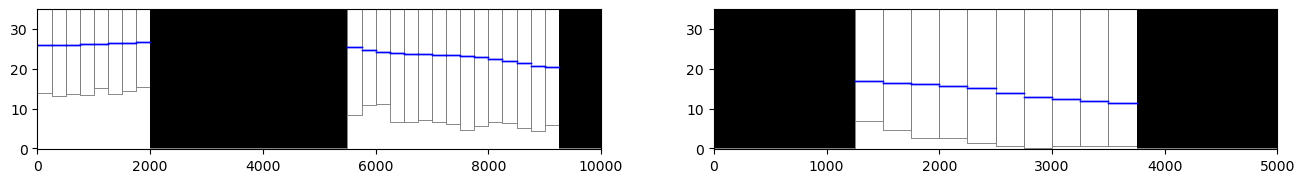

In [5]:
irow, icol = gwf.modelgrid.intersect(1200, 100)  
def beta_plot(ax):
    pmv=flopy.plot.PlotCrossSection(model=gwf,ax=ax1, line={"column": icol}) ; pmv.plot_grid(linewidth=0.5) ; pmv.plot_inactive() ; pmv.plot_surface(wt, masked_values=[1e30], color="blue", lw=1) 
    pmv=flopy.plot.PlotCrossSection(model=gwf,ax=ax2,line={"row": irow})     ; pmv.plot_grid(linewidth=0.5) ; pmv.plot_inactive() ; pmv.plot_surface(wt, masked_values=[1e30], color="blue", lw=1) 
plt.figure(figsize=(16,4))    ;ax1 = plt.subplot2grid((2,2),(0,0),colspan=1,rowspan=1); ax2 = plt.subplot2grid((2,2),(0,1),colspan=2,rowspan=1)    ; beta_plot(ax1) ; beta_plot(ax2) 

In [6]:
wel=gwf.get_package("WEL-1") ;sat_thk=gwf.modelgrid.saturated_thickness(head,mask=[1e30]) ;thk=gwf.modelgrid.cell_thickness ;modelgrid=gwf.modelgrid

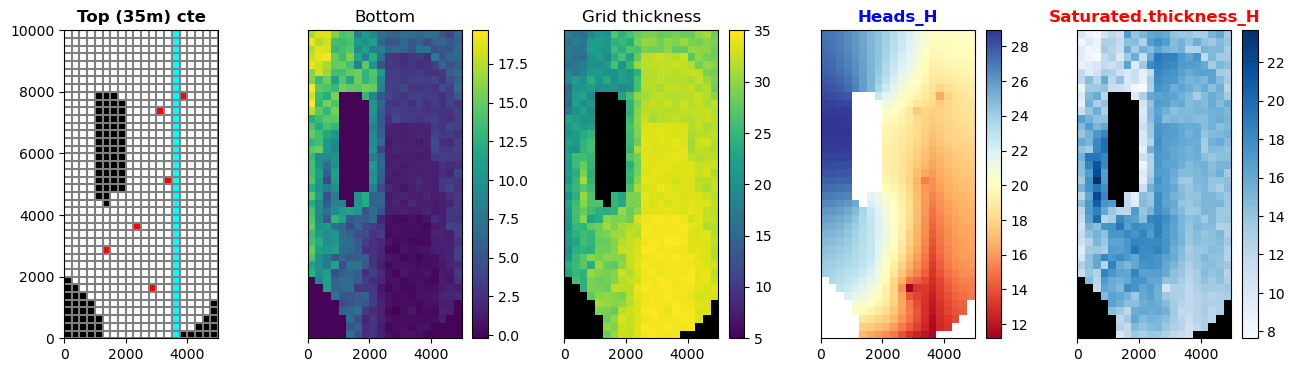

In [7]:
fig = plt.figure(figsize=(16, 4))                             
ax1 = fig.add_subplot(151) ; mm = flopy.plot.PlotMapView(model=gwf, layer=0, extent=gwf.modelgrid.extent)                     ; mm.plot_grid()                    
mm.plot_ibound(); mm.plot_bc(package=wel)             ; mm.plot_bc("CHD" , color="white" );  mm.plot_bc("RIV" , color="cyan") ; ax1.set_title("Top (35m) cte", fontweight='bold')          
ax2 = fig.add_subplot(152) ; pm = flopy.plot.PlotMapView(modelgrid=gwf.modelgrid) ; pc= pm.plot_array([bottom])               ; ax2.set_title("Bottom")                                                  ;ax2.yaxis.set_visible(False) ; plt.colorbar(pc) 
ax3 = fig.add_subplot(153) ; pm = flopy.plot.PlotMapView(modelgrid=gwf.modelgrid) ; pc= pm.plot_array(thk,vmin=5,vmax=35)     ; ax3.set_title("Grid thickness" )   ; pm.plot_ibound()                    ;ax3.yaxis.set_visible(False) ; plt.colorbar(pc) 
ax4 = fig.add_subplot(154) ; pm = flopy.plot.PlotMapView(modelgrid=gwf.modelgrid) ; pc= pm.plot_array(head, cmap='RdYlBu')    ; ax4.set_title("Heads_H", color = 'blue', fontweight='bold')              ;ax4.yaxis.set_visible(False) ; plt.colorbar(pc)
ax5 = fig.add_subplot(155) ; pm = flopy.plot.PlotMapView(modelgrid=gwf.modelgrid) ; pc= pm.plot_array(sat_thk,cmap='Blues')  ; ax5.set_title("Saturated.thickness_H", color = 'red', fontweight='bold') ;ax5.yaxis.set_visible(False) ; plt.colorbar(pc)
pm.plot_ibound(); plt.show()